In [1]:
import sys
import os

# Add Codes/src to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src')))

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

from plot_utils import plot_comparison_boxplots
from train_utils import BatteryTrainerBase, BatterySeqDataset, build_lstm_sequences, pad_collate_fn


/Users/rizqipm/Documents/USYD_MDS/DATA5703_code/CS64-Capstone/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
df = pd.read_pickle('../../../Datasets/processed/merged_interp_flat.pkl')
df.head()

,cell_id,rated_capacity,cycle_index,capacity,soh,dqdt_min,dqdt_max,dqdt_mean,dqdt_std,dvdt_min,...,i_interp_991,i_interp_992,i_interp_993,i_interp_994,i_interp_995,i_interp_996,i_interp_997,i_interp_998,i_interp_999,source
0,B0005,2.0,1,1.856487,0.928244,-1.332504e-07,0.002876,0.000528,0.000255,-0.006229,...,0.004819,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,nasa
1,B0005,2.0,3,1.846327,0.923164,-4.510385e-07,0.002894,0.000527,0.000257,-0.006004,...,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,nasa
2,B0005,2.0,5,1.835349,0.917675,-1.163391e-07,0.002333,0.000520,0.000227,-0.005953,...,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,nasa
3,B0005,2.0,7,1.835263,0.917631,-2.062661e-07,0.002885,0.000530,0.000255,-0.005907,...,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,nasa
4,B0005,2.0,9,1.834646,0.917323,-5.353266e-07,0.002896,0.000530,0.000256,-0.005923,...,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,nasa


In [5]:
# ============================
# GRU Model
# ============================
class BatteryGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=1, dropout=0, bidirectional=False, output_dim=1):
        super().__init__()
        self.gru = nn.GRU(input_dim, 
                          hidden_size=hidden_dim, 
                          num_layers=num_layers, 
                          dropout=dropout if num_layers > 1 else 0,
                          bidirectional=bidirectional, 
                          batch_first=True)
        
        direction_multiplier = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * direction_multiplier, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1])  # Use output at last time step


In [6]:
class BatteryTrainer(BatteryTrainerBase):
    def train(self, train_df, val_df, feature_cols=None, epochs=20, **model_kwargs):

        target_col = self.target_cols[0]  # should be "soh"
        train_df = train_df.copy()
        val_df = val_df.copy()

        ###
        # Min-max normalize target using train_df only (to avoid leakage)
        ###
        soh_min = train_df["soh"].min()
        soh_max = train_df["soh"].max()

        train_df[target_col] = (train_df["soh"] - soh_min) / (soh_max - soh_min)
        val_df[target_col] = (val_df["soh"] - soh_min) / (soh_max - soh_min)

        ###
        # Build full-sequence dataset (per cell)
        ###
        X_train_seq, y_train_seq = build_lstm_sequences(train_df, feature_cols, target_col)
        X_val_seq, y_val_seq = build_lstm_sequences(val_df, feature_cols, target_col)

        train_loader = DataLoader(
            BatterySeqDataset(X_train_seq, y_train_seq),
            batch_size=model_kwargs.get("batch_size", 1),
            shuffle=True,
            collate_fn=pad_collate_fn
        )

        val_loader = DataLoader(
            BatterySeqDataset(X_val_seq, y_val_seq),
            batch_size=model_kwargs.get("batch_size", 1),
            collate_fn=pad_collate_fn
        )

        ###
        # Initialize model
        ###
        model = BatteryGRU(
            input_dim=len(feature_cols),
            output_dim=1,
            hidden_dim=model_kwargs.get("hidden_dim", 128),
            num_layers=model_kwargs.get("num_layers", 2),
            dropout=model_kwargs.get("dropout", 0.0),
            bidirectional=model_kwargs.get("bidirectional", False),
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=model_kwargs.get("lr", 1e-3))
        criterion = torch.nn.MSELoss()

        ###
        # Training loop
        ###
        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                pred = model(xb).squeeze(-1)
                loss = criterion(pred, yb[:, -1])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        ###
        # Evaluation
        ###
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb).squeeze(-1)
                val_preds.append(pred.numpy())
                val_targets.append(yb[:, -1].numpy())

        val_targets = np.concatenate(val_targets)
        val_preds = np.concatenate(val_preds)

        ###
        # Denormalize target back to real SoH scale
        ###
        val_targets_real = val_targets * (soh_max - soh_min) + soh_min
        val_preds_real = val_preds * (soh_max - soh_min) + soh_min

        ###
        # Print metrics in real-world SoH
        ###
        print(f"GRU Val MSE={mean_squared_error(val_targets_real, val_preds_real):.4f}, "
            f"MAE={mean_absolute_error(val_targets_real, val_preds_real):.4f}, "
            f"R²={r2_score(val_targets_real, val_preds_real):.4f}")

        return model, val_targets_real, val_preds_real



    def optuna_objective(self, trial):
        ###
        # UBAH DISINI SESUAI MODEL MASING MASING
        ###
        hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
        num_layers = trial.suggest_int("num_layers", 2, 3)
        dropout = trial.suggest_float("dropout", 0.0, 0.5)
        bidirectional = trial.suggest_categorical("bidirectional", [False, True])
        lr = trial.suggest_categorical("lr", [1e-3, 1e-4])   
        batch_size = trial.suggest_categorical("batch_size", [1, 4, 8])

        result = self.cross_validate(
            lr=lr,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_size=batch_size
            )
        
        # for robust
        std_mse = np.std(result.mse)
        score = result.avg_mse + 0.8 * std_mse # we can tune the weight

        return score

In [7]:
trainer = BatteryTrainer(df, target_cols=['soh'])

In [8]:
trainer.cross_validate()


=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0121, MAE=0.0806, R²=0.3936
  MSE: 0.0121, MAE: 0.0806, R²: 0.3936

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0101, MAE=0.0809, R²=0.4082
  MSE: 0.0101, MAE: 0.0809, R²: 0.4082

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0113, MAE=0.0778, R²=0.2748
  MSE: 0.0113, MAE: 0.0778, R²: 0.2748

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0128, MAE=0.0861, R²=0.3559
  MSE: 0.0128, MAE: 0.0861, R²: 0.3559

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0252, MAE=0.1047, R²=-0.2633
  MSE: 0.0252, MAE: 0.1047, R²: -0.2633

=== Average 

CVResult(mse=[0.012117065982805996, 0.010058412547094078, 0.011255355127835131, 0.012847996168909642, 0.025243696920917835], mae=[0.08062715330771733, 0.08091175413860972, 0.07777344962068147, 0.08607330671616625, 0.10470593075531248], r2=[0.3936224709707401, 0.4082014177258273, 0.27483733224822393, 0.35591660986463736, -0.2633227995507277], avg_mse=np.float64(0.014304505349512536), avg_mae=np.float64(0.08601831890769746), avg_r2=np.float64(0.2338510062517402))

In [9]:
study = trainer.run_optuna_tuning()

[I 2025-04-17 13:24:39,183] A new study created in memory with name: no-name-2d6cd779-ad89-47ab-9de3-e5906cf6c5b4



=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0032, MAE=0.0311, R²=0.9321
  MSE: 0.0032, MAE: 0.0311, R²: 0.9321

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0021, MAE=0.0183, R²=0.9482
  MSE: 0.0021, MAE: 0.0183, R²: 0.9482

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0024, MAE=0.0213, R²=0.9612
  MSE: 0.0024, MAE: 0.0213, R²: 0.9612

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0020, MAE=0.0232, R²=0.9598
  MSE: 0.0020, MAE: 0.0232, R²: 0.9598

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


[I 2025-04-17 13:26:11,478] Trial 0 finished with value: 0.0026956143735730777 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.07800932022121826, 'bidirectional': False, 'lr': 0.001, 'batch_size': 8}. Best is trial 0 with value: 0.0026956143735730777.


GRU Val MSE=0.0020, MAE=0.0248, R²=0.9582
  MSE: 0.0020, MAE: 0.0248, R²: 0.9582

=== Average CV Performance ===
Avg MSE: 0.0023
Avg MAE: 0.0237
Avg R² : 0.9519

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0057, MAE=0.0292, R²=0.8791
  MSE: 0.0057, MAE: 0.0292, R²: 0.8791

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0071, MAE=0.0315, R²=0.8291
  MSE: 0.0071, MAE: 0.0315, R²: 0.8291

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0032, MAE=0.0265, R²=0.9470
  MSE: 0.0032, MAE: 0.0265, R²: 0.9470

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0040, MAE=0.0269, R²=0.9196
  MSE: 0.0040, MAE: 0.0269, R²: 0.9196

=== Fold 5 ===
[nasa] Normalizing 2014 features
[o

[I 2025-04-17 13:27:03,811] Trial 1 finished with value: 0.005844937319141673 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.15212112147976886, 'bidirectional': False, 'lr': 0.0001, 'batch_size': 8}. Best is trial 0 with value: 0.0026956143735730777.


GRU Val MSE=0.0014, MAE=0.0182, R²=0.9708
  MSE: 0.0014, MAE: 0.0182, R²: 0.9708

=== Average CV Performance ===
Avg MSE: 0.0043
Avg MAE: 0.0265
Avg R² : 0.9091

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0023, MAE=0.0220, R²=0.9704
  MSE: 0.0023, MAE: 0.0220, R²: 0.9704

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0069, MAE=0.0520, R²=0.8973
  MSE: 0.0069, MAE: 0.0520, R²: 0.8973

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0025, MAE=0.0270, R²=0.9691
  MSE: 0.0025, MAE: 0.0270, R²: 0.9691

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0027, MAE=0.0273, R²=0.9601
  MSE: 0.0027, MAE: 0.0273, R²: 0.9601

=== Fold 5 ===
[nasa] Normalizing 2014 features
[o

[I 2025-04-17 13:31:01,929] Trial 2 finished with value: 0.006690226451704343 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.29620728443102123, 'bidirectional': True, 'lr': 0.001, 'batch_size': 4}. Best is trial 0 with value: 0.0026956143735730777.


GRU Val MSE=0.0086, MAE=0.0548, R²=0.8890
  MSE: 0.0086, MAE: 0.0548, R²: 0.8890

=== Average CV Performance ===
Avg MSE: 0.0046
Avg MAE: 0.0366
Avg R² : 0.9372

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0148, MAE=0.0869, R²=0.2610
  MSE: 0.0148, MAE: 0.0869, R²: 0.2610

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0087, MAE=0.0789, R²=0.4888
  MSE: 0.0087, MAE: 0.0789, R²: 0.4888

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0132, MAE=0.0900, R²=0.1494
  MSE: 0.0132, MAE: 0.0900, R²: 0.1494

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0106, MAE=0.0791, R²=0.4693
  MSE: 0.0106, MAE: 0.0791, R²: 0.4693

=== Fold 5 ===
[nasa] Normalizing 2014 features
[o

[I 2025-04-17 13:36:17,731] Trial 3 finished with value: 0.014053190956120122 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.06101911742238941, 'bidirectional': False, 'lr': 0.001, 'batch_size': 1}. Best is trial 0 with value: 0.0026956143735730777.


GRU Val MSE=0.0140, MAE=0.0837, R²=0.3011
  MSE: 0.0140, MAE: 0.0837, R²: 0.3011

=== Average CV Performance ===
Avg MSE: 0.0122
Avg MAE: 0.0837
Avg R² : 0.3339

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0021, MAE=0.0196, R²=0.9545
  MSE: 0.0021, MAE: 0.0196, R²: 0.9545

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0063, MAE=0.0339, R²=0.8482
  MSE: 0.0063, MAE: 0.0339, R²: 0.8482

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0009, MAE=0.0137, R²=0.9846
  MSE: 0.0009, MAE: 0.0137, R²: 0.9846

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0008, MAE=0.0131, R²=0.9844
  MSE: 0.0008, MAE: 0.0131, R²: 0.9844

=== Fold 5 ===
[nasa] Normalizing 2014 features
[o

[I 2025-04-17 13:39:05,106] Trial 4 finished with value: 0.004267647403099836 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.46974947078209456, 'bidirectional': False, 'lr': 0.001, 'batch_size': 8}. Best is trial 0 with value: 0.0026956143735730777.


GRU Val MSE=0.0032, MAE=0.0294, R²=0.9335
  MSE: 0.0032, MAE: 0.0294, R²: 0.9335

=== Average CV Performance ===
Avg MSE: 0.0027
Avg MAE: 0.0219
Avg R² : 0.9410

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0165, MAE=0.0897, R²=0.1720
  MSE: 0.0165, MAE: 0.0897, R²: 0.1720

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0089, MAE=0.0738, R²=0.4752
  MSE: 0.0089, MAE: 0.0738, R²: 0.4752

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0287, MAE=0.1316, R²=-0.8487
  MSE: 0.0287, MAE: 0.1316, R²: -0.8487

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0230, MAE=0.1134, R²=-0.1536
  MSE: 0.0230, MAE: 0.1134, R²: -0.1536

=== Fold 5 ===
[nasa] Normalizing 2014 feature

[I 2025-04-17 13:44:17,394] Trial 5 finished with value: 0.025237955453540396 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.14046725484369038, 'bidirectional': False, 'lr': 0.001, 'batch_size': 1}. Best is trial 0 with value: 0.0026956143735730777.


GRU Val MSE=0.0222, MAE=0.1099, R²=-0.1126
  MSE: 0.0222, MAE: 0.1099, R²: -0.1126

=== Average CV Performance ===
Avg MSE: 0.0199
Avg MAE: 0.1037
Avg R² : -0.0935

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0104, MAE=0.0715, R²=0.4820
  MSE: 0.0104, MAE: 0.0715, R²: 0.4820

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0205, MAE=0.0965, R²=-0.2080
  MSE: 0.0205, MAE: 0.0965, R²: -0.2080

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0116, MAE=0.0887, R²=0.2536
  MSE: 0.0116, MAE: 0.0887, R²: 0.2536

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0131, MAE=0.0896, R²=0.3451
  MSE: 0.0131, MAE: 0.0896, R²: 0.3451

=== Fold 5 ===
[nasa] Normalizing 2014 featur

[I 2025-04-17 13:52:19,640] Trial 6 finished with value: 0.016406922764583914 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.38563517334297287, 'bidirectional': True, 'lr': 0.0001, 'batch_size': 1}. Best is trial 0 with value: 0.0026956143735730777.


GRU Val MSE=0.0120, MAE=0.0804, R²=0.3973
  MSE: 0.0120, MAE: 0.0804, R²: 0.3973

=== Average CV Performance ===
Avg MSE: 0.0135
Avg MAE: 0.0853
Avg R² : 0.2540

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0055, MAE=0.0361, R²=0.9289
  MSE: 0.0055, MAE: 0.0361, R²: 0.9289

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0056, MAE=0.0476, R²=0.9168
  MSE: 0.0056, MAE: 0.0476, R²: 0.9168

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0026, MAE=0.0340, R²=0.9679
  MSE: 0.0026, MAE: 0.0340, R²: 0.9679

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0069, MAE=0.0432, R²=0.8994
  MSE: 0.0069, MAE: 0.0432, R²: 0.8994

=== Fold 5 ===
[nasa] Normalizing 2014 features
[o

[I 2025-04-17 13:55:17,398] Trial 7 finished with value: 0.008373441880457886 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.44360637128816327, 'bidirectional': False, 'lr': 0.0001, 'batch_size': 4}. Best is trial 0 with value: 0.0026956143735730777.


GRU Val MSE=0.0107, MAE=0.0499, R²=0.8615
  MSE: 0.0107, MAE: 0.0499, R²: 0.8615

=== Average CV Performance ===
Avg MSE: 0.0063
Avg MAE: 0.0421
Avg R² : 0.9149

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0014, MAE=0.0185, R²=0.9695
  MSE: 0.0014, MAE: 0.0185, R²: 0.9695

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0070, MAE=0.0234, R²=0.8304
  MSE: 0.0070, MAE: 0.0234, R²: 0.8304

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0027, MAE=0.0236, R²=0.9552
  MSE: 0.0027, MAE: 0.0236, R²: 0.9552

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0034, MAE=0.0223, R²=0.9311
  MSE: 0.0034, MAE: 0.0223, R²: 0.9311

=== Fold 5 ===
[nasa] Normalizing 2014 features
[o

[I 2025-04-17 13:56:09,914] Trial 8 finished with value: 0.004809422186827341 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.015714592843367126, 'bidirectional': False, 'lr': 0.0001, 'batch_size': 8}. Best is trial 0 with value: 0.0026956143735730777.


GRU Val MSE=0.0004, MAE=0.0099, R²=0.9914
  MSE: 0.0004, MAE: 0.0099, R²: 0.9914

=== Average CV Performance ===
Avg MSE: 0.0030
Avg MAE: 0.0195
Avg R² : 0.9355

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0150, MAE=0.0665, R²=0.8072
  MSE: 0.0150, MAE: 0.0665, R²: 0.8072

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0033, MAE=0.0290, R²=0.9512
  MSE: 0.0033, MAE: 0.0290, R²: 0.9512

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0021, MAE=0.0276, R²=0.9742
  MSE: 0.0021, MAE: 0.0276, R²: 0.9742

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0020, MAE=0.0257, R²=0.9707
  MSE: 0.0020, MAE: 0.0257, R²: 0.9707

=== Fold 5 ===
[nasa] Normalizing 2014 features
[o

[I 2025-04-17 14:04:11,351] Trial 9 finished with value: 0.00969037469518643 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.46484882617128653, 'bidirectional': False, 'lr': 0.001, 'batch_size': 4}. Best is trial 0 with value: 0.0026956143735730777.


GRU Val MSE=0.0066, MAE=0.0415, R²=0.9147
  MSE: 0.0066, MAE: 0.0415, R²: 0.9147

=== Average CV Performance ===
Avg MSE: 0.0058
Avg MAE: 0.0381
Avg R² : 0.9236

Best trial:
  MSE: 0.0027
  Params:
    hidden_dim: 128
    num_layers: 3
    dropout: 0.07800932022121826
    bidirectional: False
    lr: 0.001
    batch_size: 8


In [10]:
base_model = trainer.train_base_model()


Training base model with default hyperparameters
GRU Val MSE=0.0042, MAE=0.0346, R²=0.7906


In [11]:
tuned_model = trainer.train_tuned_model()


Training with best Optuna params:
  hidden_dim: 128
  num_layers: 3
  dropout: 0.07800932022121826
  bidirectional: False
  lr: 0.001
  batch_size: 8
GRU Val MSE=0.0012, MAE=0.0136, R²=0.9739



Running cross-validation for base model...

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0147, MAE=0.0910, R²=0.2649
  MSE: 0.0147, MAE: 0.0910, R²: 0.2649

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0136, MAE=0.0865, R²=0.2006
  MSE: 0.0136, MAE: 0.0865, R²: 0.2006

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0126, MAE=0.0808, R²=0.1855
  MSE: 0.0126, MAE: 0.0808, R²: 0.1855

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0129, MAE=0.0904, R²=0.3527
  MSE: 0.0129, MAE: 0.0904, R²: 0.3527

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
GRU Val MSE=0.0223, MAE=0.0973, R²=-0.1170
  MSE: 0.

/Users/rizqipm/Documents/USYD_MDS/DATA5703_code/CS64-Capstone/Codes/src/plot_utils.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['Metric'] == metric], x='Model', y='Score', palette='Set2', ax=ax)
/Users/rizqipm/Documents/USYD_MDS/DATA5703_code/CS64-Capstone/Codes/src/plot_utils.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['Metric'] == metric], x='Model', y='Score', palette='Set2', ax=ax)
/Users/rizqipm/Documents/USYD_MDS/DATA5703_code/CS64-Capstone/Codes/src/plot_utils.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect

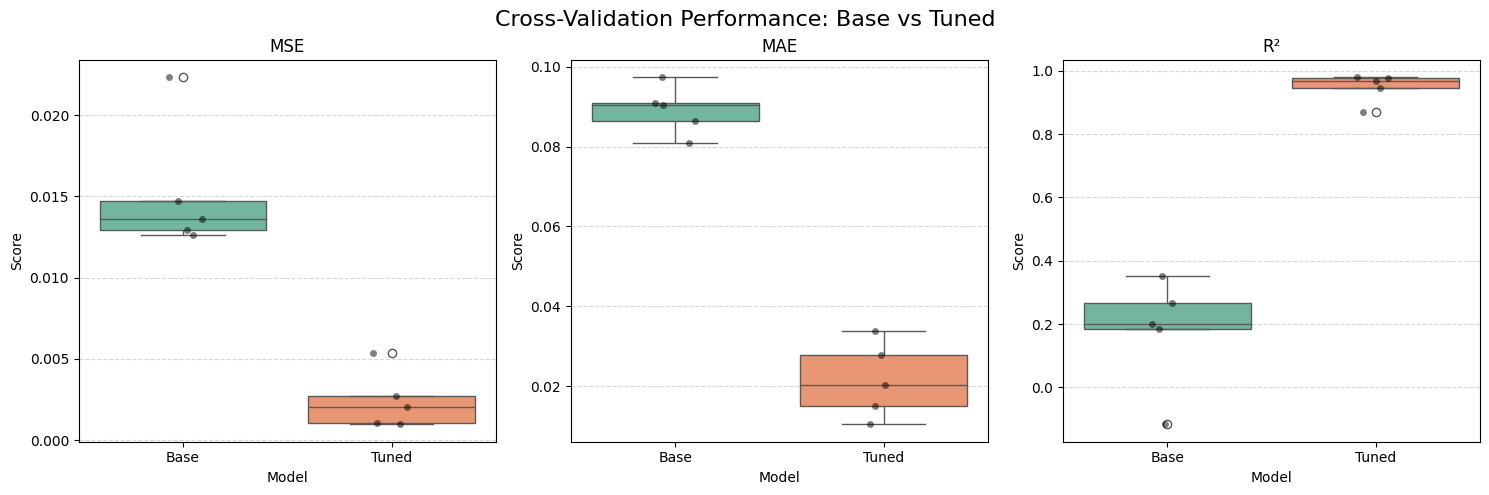

In [12]:
trainer.compare_base_vs_tuned_cv()